In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import datetime as dt
from dotenv import load_dotenv
import yfinance as yf
from pandas_datareader import data as pdr

import warnings
warnings.simplefilter(action='ignore', category=Warning)

##import hvplot.pandas
##import holoviz
##import os, holoviews as hv
##os.environ['HV_DOC_HTML'] = 'true'

# Data Collection - Oil Prices (in USD) data.
In this notebook, we will load historical Oil data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Fetch oil data from Yahoo Finance
oil = yf.Ticker("CL=F")

# get stock info
oil.info

# get historical market data
df = oil.history(period="max")

In [3]:
# Drop the column not needed and assifn to a datafram
historical_df = df.drop(['Open',"High",'Low','Dividends','Stock Splits'],axis=1)

# Add a Returns Column to the dataframe
historical_df["Return"] = historical_df["Close"].pct_change() * 100

# Drop null values
historical_df.dropna(inplace=True)

# Create a lagged return using the shift function
historical_df['Lagged_Return'] = historical_df[['Return']].shift()

# Drop null values
historical_df.dropna(inplace=True)

historical_df.head()

,Close,Volume,Return,Lagged_Return
Date,,,,
2000-08-25,32.049999,44601,1.327854,-1.310453
2000-08-28,32.869999,46770,2.558501,1.327854
2000-08-29,32.720001,49131,-0.456336,2.558501
2000-08-30,33.400002,79214,2.078240,-0.456336
2000-08-31,33.099998,56895,-0.898213,2.078240


In [4]:
historical_df.tail()

,Close,Volume,Return,Lagged_Return
Date,,,,
2022-03-03,107.669998,592031,-2.649187,6.952901
2022-03-04,115.680000,493875,7.439400,-2.649187
2022-03-07,119.400002,576022,3.215769,7.439400
2022-03-08,123.699997,576022,3.601336,3.215769
2022-03-09,110.769997,7042,-10.452709,3.601336


## Initial Time-Series Plotting

<AxesSubplot:title={'center':'Oil Prices: August 2000 - March 2022'}, xlabel='Date'>

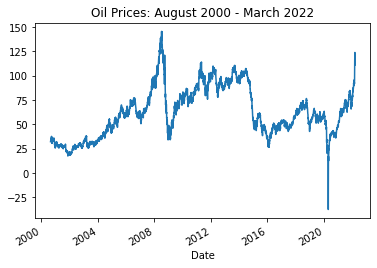

In [5]:
# Plot the Oil Close prices
historical_df.Close.plot(title="Oil Prices: August 2000 - March 2022")

In [6]:
##hv.extension('bokeh')
##hv.Curve([1, 2, 3])

<AxesSubplot:title={'center':'Oil Returns: August 2000 - March 2022'}, xlabel='Date'>

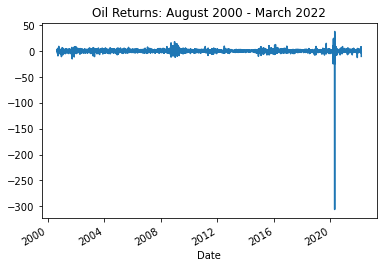

In [7]:
# Plot the Oil Returns
historical_df.Return.plot(title="Oil Returns: August 2000 - March 2022")

The dip in oil rates in 2020 was an abnormality and hence we will utilize data until Dec 2019 for our anlaysis. 

In [8]:
# Slice the data so it is until Dec 2019
historical_df = historical_df.loc[:'20191231']

<AxesSubplot:title={'center':'Oil Returns: August 2000 - December 2019'}, xlabel='Date'>

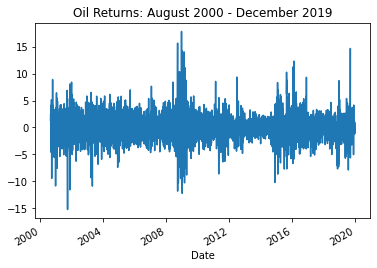

In [9]:
# Plot the Oil Returns after dropping 2020
historical_df.Return.plot(title="Oil Returns: August 2000 - December 2019")

---

# Data Modelling 

# Data Pre-Processing

Split the data into training and testing data based on date range such that 75% falls in training set and 25% fals in testing set.  

In [10]:
# Create a train/test split for the dataset
df_train = historical_df.loc['20000101':'20141231']
df_test = historical_df.loc['20140101':'20191231'] 
df_test

,Close,Volume,Return,Lagged_Return
Date,,,,
2014-01-02,95.440002,251248,-3.027836,-0.876224
2014-01-03,93.959999,215522,-1.550716,-3.027836
2014-01-06,93.430000,189379,-0.564069,-1.550716
2014-01-07,93.669998,177182,0.256875,-0.564069
2014-01-08,92.330002,244855,-1.430550,0.256875
...,...,...,...,...
2019-12-24,61.110001,204535,0.974885,0.132366
2019-12-26,61.680000,265091,0.932744,0.974885
2019-12-27,61.720001,351899,0.064852,0.932744


In [11]:
# Create four dataframes for the X y train and X y test
X_train = df_train["Lagged_Return"].to_frame()
X_test = df_test["Lagged_Return"].to_frame()

y_train = df_train["Return"]
y_test = df_test["Return"]

type(X_train)
#X_train.head()

pandas.core.frame.DataFrame

In [12]:
# No need to scale as their is only 1 feature for now
# Create the StandardScaler instance
##from sklearn.preprocessing import StandardScaler
##scaler = StandardScaler()

# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
##scaler.fit(X_train)

# Scale the features training and testing sets
##X_train = scaler.transform(X_train)
##X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
##scaler.fit(y_train)

# Model 1: Linear Regression Model

In [13]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Make predictions using test data

In [14]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [15]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

Results.describe()

,Return,Predicted Return
count,1508.000000,1508.000000
mean,-0.005913,0.043943
std,2.273072,0.083583
min,-10.232054,-0.495943
25%,-1.206040,0.000278
50%,0.050069,0.041888
75%,1.181638,0.088077
max,14.676396,0.419976


<AxesSubplot:title={'center':'Predicted Return vs Actual Return'}, xlabel='Date'>

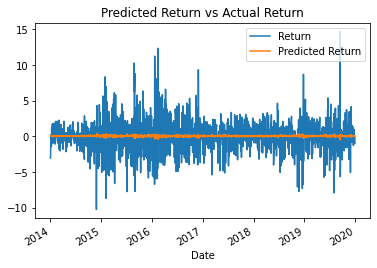

In [16]:
# Plot the predictions vs the true values
Results.plot(title = "Predicted Return vs Actual Return")
##Modify to use hvplot so it can be zoomed in

## In-Sample Performance for Linear Regression

Evaluate the model using in-sample data (X_train and y_train)

In [17]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 

# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 2.35097264822661


## Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [20]:
# Construct a dataframe using just the "y" test data:
out_sample_results = y_test.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
out_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

# Calculate out_of-sample mean_squared_error
mse = mean_squared_error(
    out_sample_results["Return"],
    out_sample_results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 2.2667143228932956


## Rolling Out-of-Sample Performance

Evaluate the model using rolling Out-of-Sample data (X_test and y_test)


In [ ]:
# Split the index into weekly periods
weeks = historical_df.index.to_period("w").unique()
print(weeks[0])

In [ ]:
# Declare the training window of 12 weeks
# Define the timeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

In [ ]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [ ]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = historical_df.loc[start_of_training_period:end_of_training_period]
    test = historical_df.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [ ]:
# Concat actual returns with out-of-sample predictions
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

# 2019 Data
Results_2019 = Results.loc['2019':]
Results_2019

In [ ]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    Results_2019["Actual Returns"],
    Results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

## Final Model Comparison

In [ ]:
# Print out-of-sample RMSE and rolling out-of-sample RMSE
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_sample_rmse}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

**Question:** How does the RMSE for the two models compare?

Answer: Comparing the two RMSE's, the RMSE from the single training window is 2.266, whereas it is 2.237 from the rolling out-of-sample model.

The rolling-out-of sample approach is an approach more appropriate to real life. The two values are close to each other which should suggest that our model is reasonably stable but the values are quite close to the standard deviation of dataset at 2.73 indicating room for improvements.

---

# Model 2: Balanced Random Forest Classifier

# Model 3: LSTM Predictor Using Closing Prices

In [46]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

df = historical_df.drop(['Close','Volume', 'Lagged_Return'],axis=1)

df.shape

# Create a train/test split for the dataset
##X_train = df.loc['20000101':'20141231']
##X_test = df.loc['20140101':'20191231'] 

##X_train.head(-1)
##X_test.head(-1)

##y_train
##y_test

,Return
Date,
2014-01-02,-3.027836
2014-01-03,-1.550716
2014-01-06,-0.564069
2014-01-07,0.256875
2014-01-08,-1.430550
...,...
2019-12-23,0.132366
2019-12-24,0.974885
2019-12-26,0.932744


In [30]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [31]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 1.32785358  2.55850145 -0.45633622  2.07824046 -0.89821269]
 [ 2.55850145 -0.45633622  2.07824046 -0.89821269  0.84592933]
 [-0.45633622  2.07824046 -0.89821269  0.84592933  1.25823294]
 [ 2.07824046 -0.89821269  0.84592933  1.25823294  3.40237146]
 [-0.89821269  0.84592933  1.25823294  3.40237146  1.08727056]] 

y sample values:
[[ 0.84592933]
 [ 1.25823294]
 [ 3.40237146]
 [ 1.08727056]
 [-4.61364558]]


In [47]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [50]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[ 1.32785358]
  [ 2.55850145]
  [-0.45633622]
  [ 2.07824046]
  [-0.89821269]]

 [[ 2.55850145]
  [-0.45633622]
  [ 2.07824046]
  [-0.89821269]
  [ 0.84592933]]

 [[-0.45633622]
  [ 2.07824046]
  [-0.89821269]
  [ 0.84592933]
  [ 1.25823294]]

 [[ 2.07824046]
  [-0.89821269]
  [ 0.84592933]
  [ 1.25823294]
  [ 3.40237146]]

 [[-0.89821269]
  [ 0.84592933]
  [ 1.25823294]
  [ 3.40237146]
  [ 1.08727056]]] 

X_test sample values:
[[[ 0.21430665]
  [ 0.70265017]
  [-0.81908946]
  [ 1.65170788]
  [ 0.67202188]]

 [[ 0.70265017]
  [-0.81908946]
  [ 1.65170788]
  [ 0.67202188]
  [-0.93653723]]

 [[-0.81908946]
  [ 1.65170788]
  [ 0.67202188]
  [-0.93653723]
  [ 0.03017075]]

 [[ 1.65170788]
  [ 0.67202188]
  [-0.93653723]
  [ 0.03017075]
  [ 0.14075949]]

 [[ 0.67202188]
  [-0.93653723]
  [ 0.03017075]
  [ 0.14075949]
  [-0.41164261]]]


## Build and Train the LSTM RNN

In [62]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [76]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [77]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [78]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 5)              140       
                                                                 
 dropout_12 (Dropout)        (None, 5, 5)              0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 5)              220       
                                                                 
 dropout_13 (Dropout)        (None, 5, 5)              0         
                                                                 
 lstm_14 (LSTM)              (None, 5)                 220       
                                                                 
 dropout_14 (Dropout)        (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [79]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
3395/3395 [==============================] - 46s 11ms/step - loss: 5.7132
Epoch 2/10
3395/3395 [==============================] - 38s 11ms/step - loss: 5.7177
Epoch 3/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.7133
Epoch 4/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.7124
Epoch 5/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.7115
Epoch 6/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.7120
Epoch 7/10
3395/3395 [==============================] - 36s 11ms/step - loss: 5.7099
Epoch 8/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.7018
Epoch 9/10
3395/3395 [==============================] - 35s 10ms/step - loss: 5.6876
Epoch 10/10
3395/3395 [==============================] - 36s 11ms/step - loss: 5.6903


## Model Performance

In [80]:
# Evaluate the model
model.evaluate(X_test, y_test)

46/46 [==============================] - 4s 6ms/step - loss: 5.3214


5.321421146392822

In [82]:
# Make some predictions
predicted = model.predict(X_test)

### Plotting Predicted Vs. Real Prices

In [83]:
predicted_prices = predicted
real_prices = y_test

In [84]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2014-03-20,-0.936537,0.071876
2014-03-21,0.030171,0.070705
2014-03-24,0.140759,0.072220
2014-03-25,-0.411643,0.067037
2014-03-26,1.078737,0.072992


<AxesSubplot:xlabel='Date'>

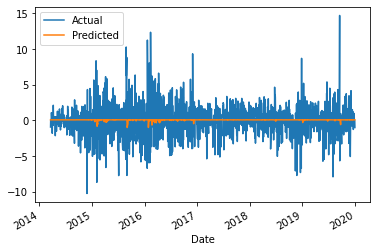

In [85]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

---

---

---

# Conclusions